In [1]:
## system package
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
sys.path.append('../')
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
## general package
import torch
import torch.nn as nn
from fastai.vision import *
from torch_lr_finder import LRFinder
from tqdm.notebook import trange, tqdm
from sklearn.metrics import cohen_kappa_score,confusion_matrix
## custom package
from input.inputPipeline import *
from model.resnext_ssl import *

  pip install torch-lr-finder -v --global-option="amp"


### dataset and dataloader

In [3]:
nfolds = 5
bs = 4
csv_file = '../input/panda-16x128x128-tiles-data/{}_fold_train.csv'.format(nfolds)
image_dir = '../input/panda-16x128x128-tiles-data/train/'
## image statistics
# mean = torch.tensor([0.90949707, 0.8188697, 0.87795304])
# std = torch.tensor([0.36357649, 0.49984502, 0.40477625])
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
## image transformation
tsfm = data_transform(mean, std)
## dataset, can fetch data by dataset[idx]
dataset = PandaPatchDataset(csv_file, image_dir, transform=tsfm)
## dataloader
dataloader = DataLoader(dataset, batch_size=bs,
                        shuffle=True, num_workers=4, collate_fn=dataloader_collte_fn)
crossValData = crossValDataloader(csv_file, dataset, bs)

### model

In [4]:
model = Model().cuda()

Using cache found in /home/wenyuan/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


### train

In [5]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)

#### Find best lr

In [6]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader, end_lr=100, num_iter=100)

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


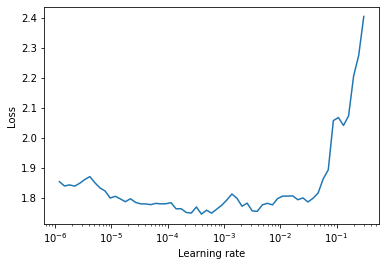

In [7]:
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

#### Simple training

In [8]:
# for i, data in enumerate(dataloader, start = 0):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs, labels = data

#     # zero the parameter gradients
#     optimizer.zero_grad()

#     # forward + backward + optimize
#     outputs = model(inputs.cuda())
#     loss = criterion(outputs, labels.cuda())
#     loss.backward()
#     optimizer.step()

#     if i % 10 == 0:
#         print(loss.item())
    
#     if i == 50:
#         break

#### One cycle scheduler

In [9]:
from onecyclelr import OneCycleLR

In [10]:
epochs = 16
# scheduler = OneCycleLR(optimizer, num_steps=epochs, lr_range=(1e-3, 1e-1))

In [11]:
# for epoch in trange(epochs, desc='epoch'):
#     for i, data in enumerate(tqdm(dataloader), start = 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs.cuda())
#         loss = criterion(outputs, labels.cuda())
#         loss.backward()
#         optimizer.step()
#     scheduler.step()
#     print("current epoch {}, loss is {}".format(epoch,loss.item()))

#### Train with val in cross-val case

In [ ]:
epochs = 16
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
# scheduler = OneCycleLR(optimizer, num_steps=epochs, lr_range=(1e-3, 1e-1))
for fold in trange(nfolds, desc='fold'):
    trainloader, valloader = crossValData(fold)
    for epoch in trange(epochs, desc='epoch'):
        ## train
        model.train()
        train_loss = []
        for i, data in enumerate(tqdm(trainloader), start = 0):
#             if i >= 50:
#                 break
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        ## val
        model.eval()
        val_loss, val_label, val_preds = [],[],[]
        with torch.no_grad():
            for i, data in enumerate(tqdm(valloader), start = 0):
#                 if i > 50:
#                     break
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(inputs.cuda())
                loss = criterion(outputs, labels.cuda())
                val_loss.append(loss.item())
                val_label.append(labels.cpu())
                val_preds.append(outputs.cpu())
#         scheduler.step()
        val_preds = torch.argmax(torch.cat(val_preds,0),1)
        val_label = torch.cat(val_label)
        kappa = cohen_kappa_score(val_label,val_preds,weights='quadratic')
        print("Epoch {}, train loss: {:.4f}, val loss: {:.4f}, kappa-score: {:.4f}".format(epoch,
                                                                                        np.mean(train_loss),
                                                                                        np.mean(val_loss),
                                                                                        kappa))


Epoch 0, train loss: 1.7095, val loss: 1.7719, kappa-score: 0.3122



Epoch 1, train loss: 1.6569, val loss: 1.6057, kappa-score: 0.3919



Epoch 2, train loss: 1.6388, val loss: 1.5892, kappa-score: 0.3509
